# Imports

In [106]:
%load_ext autoreload
%autoreload 2

import os 
import sys
sys.path.append('./..')
sys.path.append('./../..')
import logging

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
from ipywidgets import interact

import dynaphos
from dynaphos import utils
from dynaphos import cortex_models
from dynaphos.cortex_models import get_visual_field_coordinates_from_cortex_full, Map
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator

import math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulator

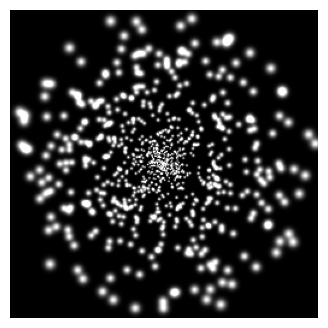

In [107]:
# Load the simulator configuration file (and adjust to preferences).
params = utils.load_params('../config/params.yaml')

# Get phosphene coordinates...
n_phosphenes = 1024
phosphene_coords = cortex_models.get_visual_field_coordinates_probabilistically(params, n_phosphenes)

# Initialize simulator
simulator = PhospheneSimulator(params, phosphene_coords)

# Stimulation amplitude
amplitude = params['sampling']['stimulus_scale'] # Ampère (160 µA)

# Stimulation vector
stim = amplitude * torch.ones(n_phosphenes).cuda().detach() # (All electrodes are activated)

# Reset and call the simulator
simulator.reset()
phosphenes = simulator(stim)

# Show the phosphene image
plt.figure(figsize=(4, 4))
plt.imshow(phosphenes.cpu()[0], cmap='gray')
plt.axis('off')
plt.show()

# Uniformity

In [108]:
from phosphene.uniformity import DynamicAmplitudeNormalizer

Loss = 0.0263:   0%|                                                                                                                                                                                                                                                                                                              | 0/2000 [00:00<?, ?iter/s]

Loss = 0.0032: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:08<00:00, 231.71iter/s]


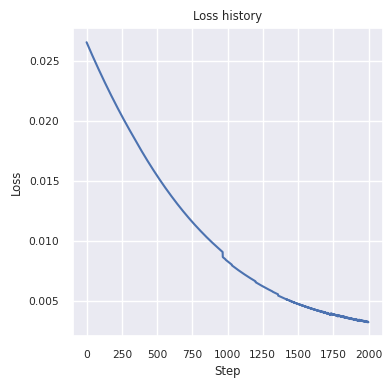

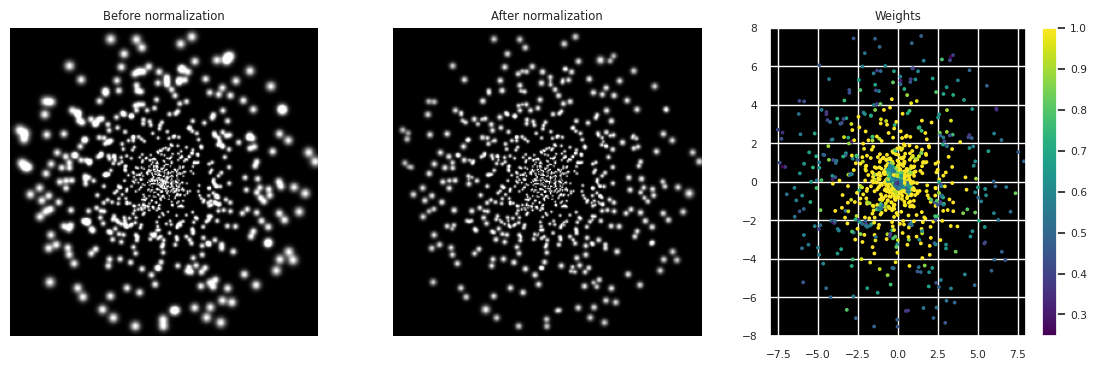

Percentage of amplitude: 76.03%


In [109]:
stim_init = amplitude * torch.ones(simulator.num_phosphenes, device='cuda')

normalizer = DynamicAmplitudeNormalizer(
    simulator=simulator,
    base_size=3,
    scale=0.0001,
    A_min=0,
    A_max=amplitude,
    learning_rate=0.002,
    steps=2000,
    target=None  # or a specific float
)
stim_final = normalizer.run(stim_init, verbose=True)
stim_weights = normalizer.weights

# plot the loss_history from the normalizer
plt.figure(figsize=(4, 4))
plt.plot(normalizer.loss_history)
plt.xlabel('Step')
plt.ylabel('Loss')
plt.title('Loss history')
plt.show()

# Visualize
simulator.reset()
phos_image_before = simulator(stim_init)
simulator.reset()
phos_image_after  = simulator(stim_init * stim_weights)

# visualize the phosphene images and the weights in a scatterplot
plt.figure(figsize=(14, 4))
plt.subplot(1, 3, 1)
plt.imshow(phos_image_before.cpu()[0], cmap='gray')
plt.axis('off')
plt.title('Before normalization')

plt.subplot(1, 3, 2)
plt.imshow(phos_image_after.cpu()[0], cmap='gray')
plt.axis('off')
plt.title('After normalization')

plt.subplot(1, 3, 3)
phosphene_coords = simulator.coordinates
plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=stim_weights.cpu(), cmap='viridis', s=3)
# extend the axes to the full image size
fov = simulator.params['run']['view_angle']
plt.xlim(-fov/2, fov/2)
plt.ylim(-fov/2, fov/2)
# black background
plt.gca().set_facecolor('black')
plt.colorbar()
plt.title('Weights')
plt.show()

# percentage of amplitude compared to full amplitude
print(f'Percentage of amplitude: {stim_weights.sum() / simulator.num_phosphenes*100:.2f}%')

# Phosphene Density Maps

In [110]:
from phosphene.density import VisualFieldMapper

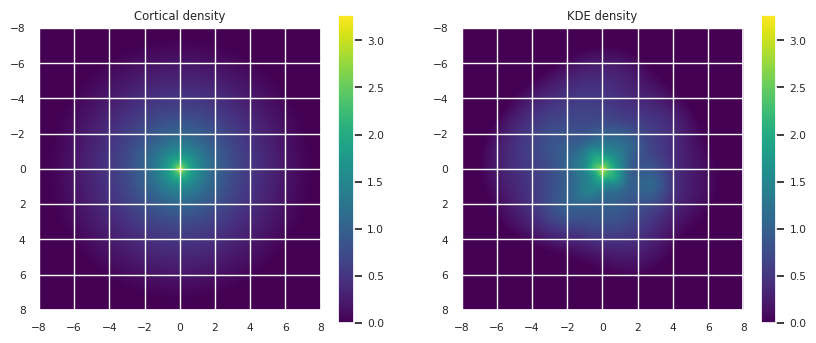

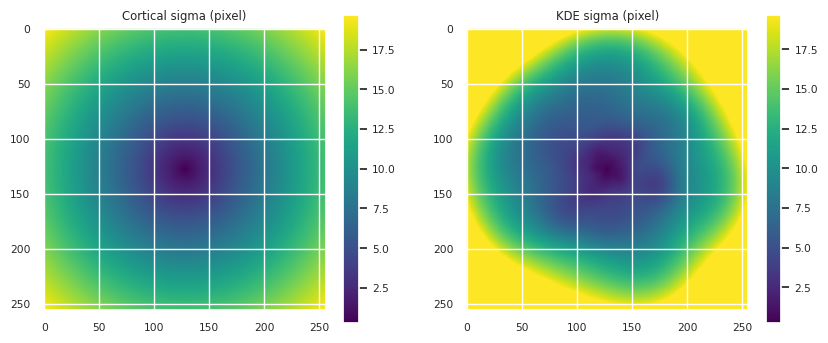

In [111]:
mapper = VisualFieldMapper(simulator=simulator)

# 1) Cortical approach:
density_cortical = mapper.build_density_map_cortical(total_phosphenes=1024)
sigma_cortical_fov = mapper.build_sigma_map_from_density(density_cortical, space="fov")
sigma_cortical_pix = mapper.build_sigma_map_from_density(density_cortical, space="pixel")

# 2) KDE approach:
density_kde = mapper.build_density_map_kde(k=16, alpha=1.0, total_phosphenes=1024)
sigma_kde_fov = mapper.build_sigma_map_from_density(density_kde, space="fov")
sigma_kde_pix = mapper.build_sigma_map_from_density(density_kde, space="pixel")

# show density maps
fov = params['run']['view_angle']

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.log10(density_cortical), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmin=0)
plt.colorbar()
plt.title('Cortical density')

plt.subplot(1, 2, 2)
plt.imshow(np.log10(density_kde), cmap='viridis', extent=[-fov/2, fov/2, fov/2, -fov/2], vmax=np.log10(density_cortical.max()), vmin=0)
plt.colorbar()
plt.title('KDE density')
plt.show()

# plot sigma_cortical_pix, sigma_kde_pix
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(sigma_cortical_pix, cmap='viridis')
plt.colorbar()
plt.title('Cortical sigma (pixel)')

plt.subplot(1, 2, 2)
plt.imshow(sigma_kde_pix, cmap='viridis', vmax=sigma_cortical_pix.max())
plt.colorbar()
plt.title('KDE sigma (pixel)')
plt.show()

# Image processing for Phosphene Vision

In [112]:
from spatial_frequency.components.SeparableModulated2d import SeparableModulatedConv2d
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

# 1) Define your weighted‐grayscale Lambda
rgb_weights = torch.tensor([0.2126, 0.7152, 0.0722]).view(3,1,1)
to_weighted_grayscale = transforms.Lambda(
    lambda img: (img * rgb_weights).sum(dim=0, keepdim=True)
)

# 2) Build your full pipeline
t = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),            # → [C,H,W] in [0,1]
    to_weighted_grayscale,            # → [1,H,W] weighted luma
])

data_loader = DataLoader(
    ImageFolder('/projects/prjs0344/Dynaphos/data/example_faces_LaPa/', transform=t),
    batch_size=1,
    shuffle=False
)


In [113]:
def robust_percentile_normalization(electrode, amplitude, threshold, low_perc=5, high_perc=95, gamma=1.0):
    """
    Normalize the stimulation vector in a robust, contrast-preserving way.

    This function performs the following steps:
      1. Subtracts a given threshold (values below threshold become 0).
      2. Computes low and high percentiles (e.g., 5th and 95th) of the resulting values.
      3. Linearly scales values between these percentiles to [0, 1], then applies an optional gamma correction.
      4. Scales the result to the desired amplitude.

    Args:
        electrode (torch.Tensor): Input stimulation values.
        amplitude (float): Desired maximum amplitude.
        threshold (float): Activation threshold (e.g. your activation_threshold).
        low_perc (float): Lower percentile (default 5).
        high_perc (float): Upper percentile (default 95).
        gamma (float): Gamma exponent for power-law scaling (default 1.0 means linear scaling).
        
    Returns:
        torch.Tensor: Normalized stimulation values, with zeros preserved.
    """
    # Subtract threshold and clamp to 0 so that values below threshold remain 0.
    above_thresh = electrode - threshold
    above_thresh = torch.clamp(above_thresh, min=0.0)
    
    # Compute robust lower and upper bounds using percentiles.
    # Use torch.quantile (available in PyTorch 1.7+; adjust if needed).
    low_val = torch.quantile(above_thresh, low_perc / 100.0)
    high_val = torch.quantile(above_thresh, high_perc / 100.0)
    
    # Avoid division by zero if high_val == low_val.
    range_val = high_val - low_val + 1e-8

    # Linearly map values in the range [low_val, high_val] to [0, 1]
    normalized = (above_thresh - low_val) / range_val
    normalized = torch.clamp(normalized, 0.0, 1.0)

    # Apply gamma correction to adjust contrast if needed.
    normalized = normalized ** gamma

    # Scale to the desired amplitude.
    normalized = normalized * amplitude

    return normalized


# Dilation is used for the reg-loss on the phosphene image: phosphenes do not have to map 1 on 1, small offset is allowed.
def dilation5x5(img, kernel=None):
    if kernel is None:
        kernel = torch.tensor([[[[0., 0., 1., 0., 0.],
                              [0., 1., 1., 1., 0.],
                              [1., 1., 1., 1., 1.],
                              [0., 1., 1., 1., 0.],
                              [0., 0., 1., 0., 0.]]]], requires_grad=False, device=img.device)
    return torch.clamp(torch.nn.functional.conv2d(img, kernel, padding=kernel.shape[-1]//2), 0, 1)

def dilation3x3(img, kernel=None):
    if kernel is None:
        kernel = torch.tensor([[[
                              [ 0, 1., 0.],
                              [ 1., 1., 1.],
                              [ 0., 1., 0.],]]], requires_grad=False, device=img.device)
    return torch.clamp(torch.nn.functional.conv2d(img, kernel, padding=kernel.shape[-1]//2), 0, 1)

In [114]:
sigma_map_tensor = torch.tensor(sigma_kde_pix).float().cuda().detach()

mod_layer = SeparableModulatedConv2d(
    in_channels=1,
    sigma_map=sigma_map_tensor
).cuda()
mod_layer.eval()

SeparableModulatedConv2d()

In [115]:
def rand_perlin_2d(shape, res, fade = lambda t: 6*t**5 - 15*t**4 + 10*t**3):
    delta = (res[0] / shape[0], res[1] / shape[1])
    d = (shape[0] // res[0], shape[1] // res[1])
    
    grid = torch.stack(torch.meshgrid(torch.arange(0, res[0], delta[0]), torch.arange(0, res[1], delta[1])), dim = -1) % 1
    angles = 2*math.pi*torch.rand(res[0]+1, res[1]+1)
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim = -1)
    
    tile_grads = lambda slice1, slice2: gradients[slice1[0]:slice1[1], slice2[0]:slice2[1]].repeat_interleave(d[0], 0).repeat_interleave(d[1], 1)
    dot = lambda grad, shift: (torch.stack((grid[:shape[0],:shape[1],0] + shift[0], grid[:shape[0],:shape[1], 1] + shift[1]  ), dim = -1) * grad[:shape[0], :shape[1]]).sum(dim = -1)
    
    n00 = dot(tile_grads([0, -1], [0, -1]), [0,  0])
    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0])
    n01 = dot(tile_grads([0, -1],[1, None]), [0, -1])
    n11 = dot(tile_grads([1, None], [1, None]), [-1,-1])
    t = fade(grid[:shape[0], :shape[1]])
    return math.sqrt(2) * torch.lerp(torch.lerp(n00, n10, t[..., 0]), torch.lerp(n01, n11, t[..., 0]), t[..., 1])

In [116]:
import torch
import numpy as np
import cv2

def make_stim_phos(simulator, stim: torch.Tensor, amplitude, threshold, stim_weights):
    """
    stim: [B, C, H, W]
    returns: (stim, phos) both [B, C, H, W]
    """
    simulator.reset()
    elec = simulator.sample_stimulus(stim, rescale=True)
    elec = robust_percentile_normalization(
        elec,
        amplitude,
        threshold=threshold,
        low_perc=5,
        high_perc=90,
        gamma=2/3
    )
    elec = elec * stim_weights
    phos = simulator(elec)

    # ensure [B,C,H,W]
    if phos.dim() == 2:          # [H,W]
        phos = phos.unsqueeze(0).unsqueeze(0)
    elif phos.dim() == 3:        # [C,H,W]
        phos = phos.unsqueeze(0)
    return stim, phos

image_processing_dict = {}
threshold = params['thresholding']['rheobase']

for idx, (images, _) in enumerate(data_loader):
    images = images.cuda()             # [1,1,H,W]
    orig = images                    

    # DoG
    dog = mod_layer(orig)
    dog = dog.detach().cpu().clip(0, None)
    dog = (dog - dog.min())/(dog.max()-dog.min())
    dog = dog.cuda()

    # Canny
    npimg = (orig[0,0].cpu().numpy()*255).astype(np.uint8)
    ce = cv2.Canny(npimg,120,200).astype(np.float32)  # [H,W]
    # dilate 3x3
    ce = dilation3x3(torch.from_numpy(ce).unsqueeze(0)).squeeze(0).cpu().numpy()
    ce = torch.from_numpy(ce / (ce.max()+1e-8)).unsqueeze(0).unsqueeze(0).cuda()

    # Random Perlin (fixed)
    rp = rand_perlin_2d((256,256),(4,4))    # returns a torch.Tensor [H,W]
    rp = rp.float()                         # ensure float
    rp = (rp - rp.min())/(rp.max()-rp.min())
    rp = rp.unsqueeze(0).unsqueeze(0).cuda()  # [1,1,H,W]

    # stimulate & simulate
    stim_gs, phos_gs   = make_stim_phos(simulator, orig,  amplitude, threshold, stim_weights)
    stim_dog, phos_dog = make_stim_phos(simulator, dog,   amplitude, threshold, stim_weights)
    stim_ce, phos_ce   = make_stim_phos(simulator, ce,    amplitude, threshold, stim_weights)
    stim_rp, phos_rp   = make_stim_phos(simulator, rp,    amplitude, threshold, stim_weights)

    image_processing_dict[idx] = {
        'image': orig,            
        'grayscale': {
            'stim': stim_gs,       
            'phosphenes': phos_gs 
        },
        'DoG_response': {
            'stim': stim_dog,      
            'phosphenes': phos_dog
        },
        'canny_edge': {
            'stim': stim_ce,       
            'phosphenes': phos_ce
        },
        'random': {
            'stim': stim_rp,       
            'phosphenes': phos_rp
        }
    }

    if idx == 250:
        break


In [117]:
torch.use_deterministic_algorithms(False)

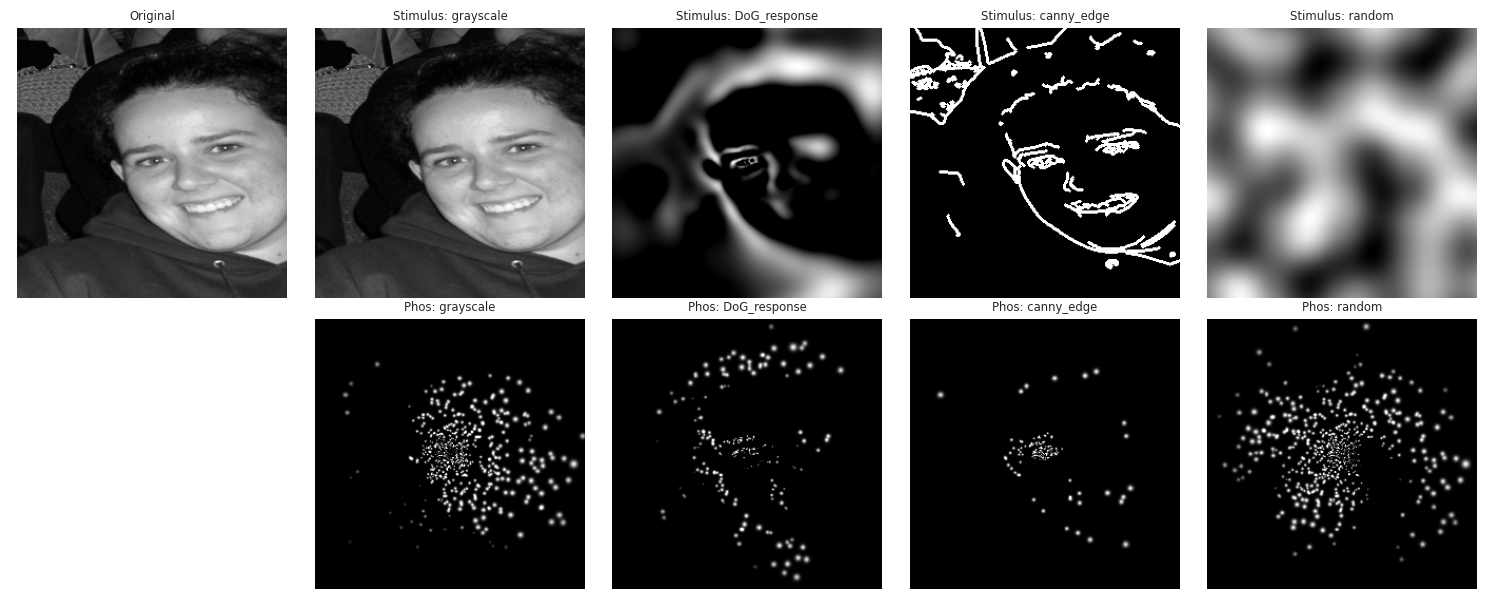

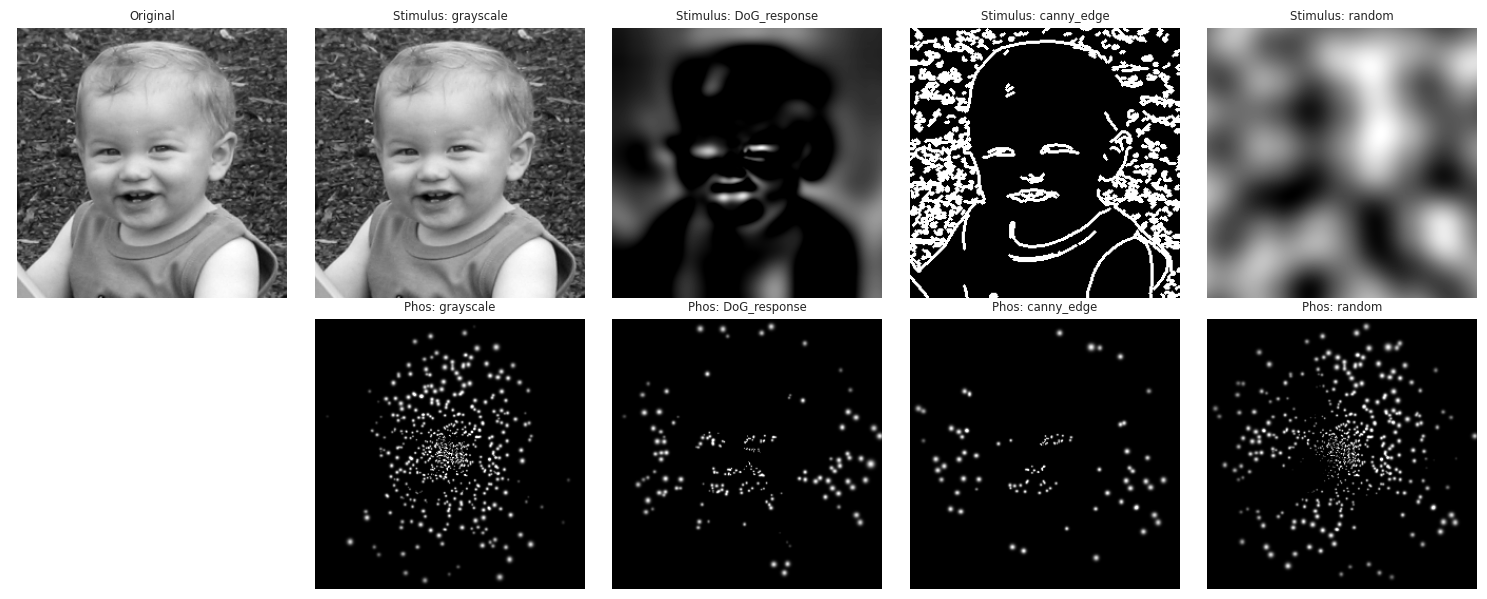

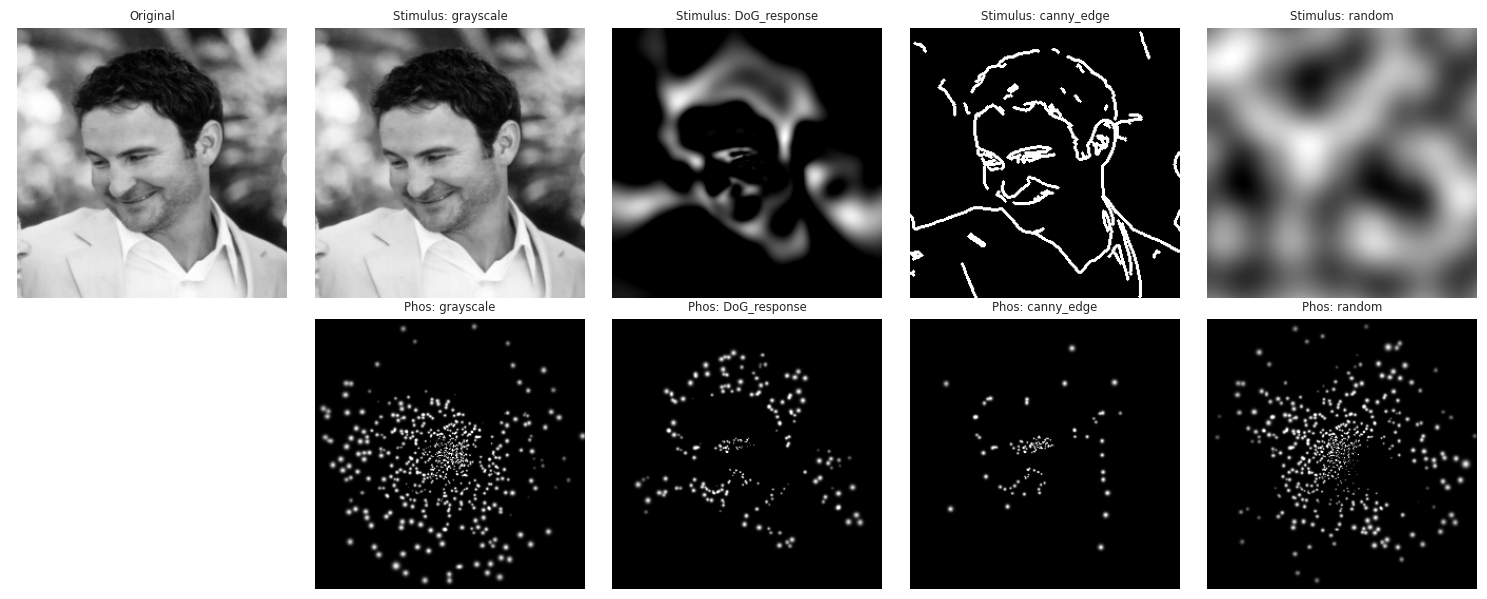

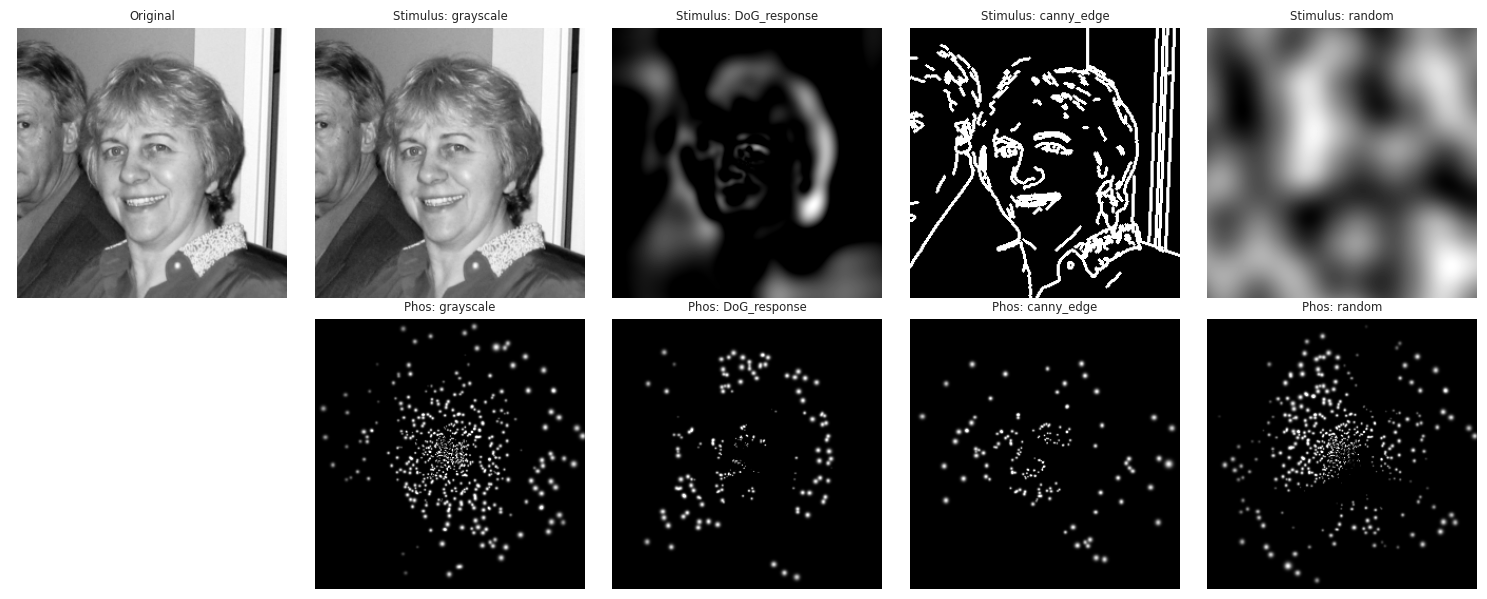

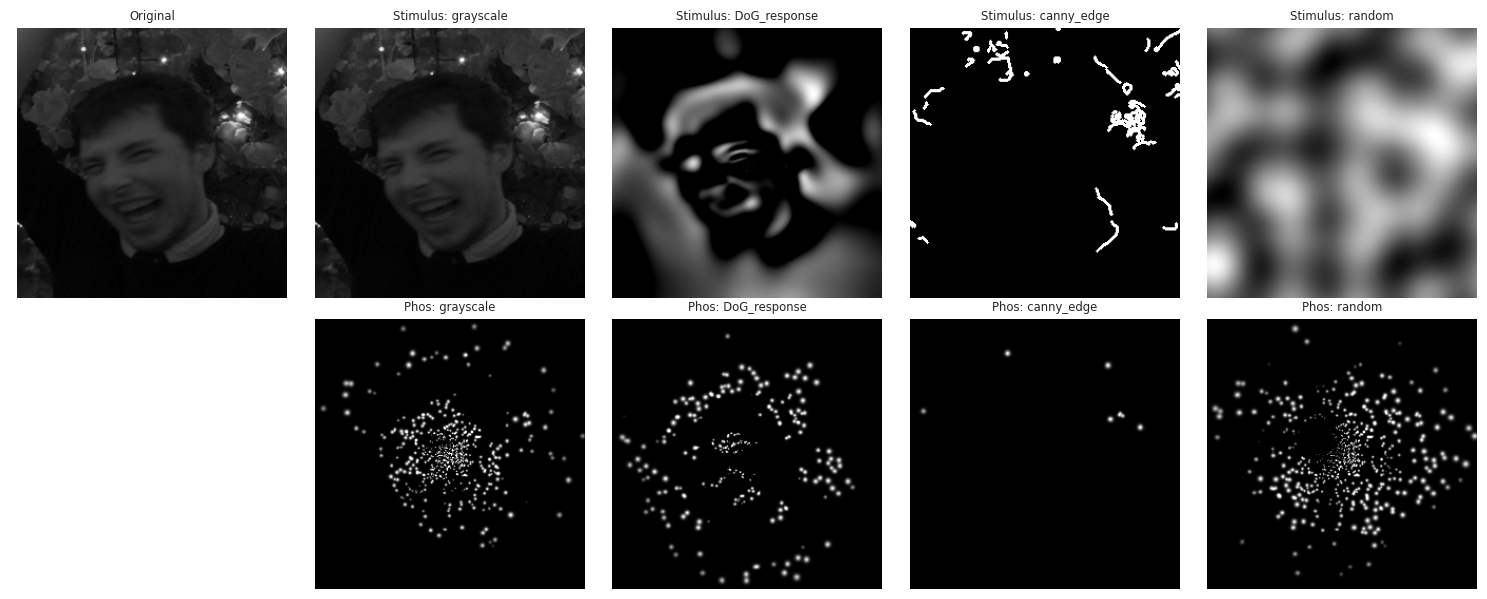

In [139]:
import matplotlib.pyplot as plt

def show_images(idx):
    data   = image_processing_dict[idx]
    # collect all the keys except the raw 'image'
    methods = [k for k in data.keys() if k != 'image']
    n_cols  = 1 + len(methods)   # one column for the original + one for each method

    fig, axes = plt.subplots(2, n_cols,
                             figsize=(3*n_cols, 6),
                             squeeze=False)

    # --- Row 0, Col 0: the original ---
    orig = data['image'][0, 0].cpu().numpy()
    ax = axes[0, 0]
    ax.imshow(orig, cmap='gray')
    ax.set_title('Original')
    ax.axis('off')

    # leave the bottom-left empty (no phos for original)
    axes[1, 0].axis('off')

    for j, key in enumerate(methods, start=1):
        stim = data[key]['stim'][0, 0].cpu().numpy()
        phos = data[key]['phosphenes'][0, 0].cpu().numpy()

        # stimulus in row 0
        ax = axes[0, j]
        ax.imshow(stim, cmap='gray')
        ax.set_title(f'Stimulus: {key}')
        ax.axis('off')

        # phosphenes in row 1
        ax = axes[1, j]
        ax.imshow(phos, cmap='gray')
        ax.set_title(f'Phos: {key}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()

show_images(0)  # Show the first example
show_images(1)  # Show the second example
show_images(2)  # Show the third example
show_images(3)  # Show the fourth example
show_images(4)  # Show the fifth example

In [119]:
# # print all the shapes of the image_processing_dict content
# for idx, data in image_processing_dict.items():
#     print(f"Image {idx}:")
#     print(f"  Original Image Shape: {data['image'].shape}")
#     for key, value in data.items():
#         if key != 'image':
#             print(f"  {key} Stimulus Shape: {value['stim'].shape}")
#             print(f"  {key} Phosphenes Shape: {value['phosphenes'].shape}")
#     print()  # Newline for better readability
    

# Evaluate

In [120]:
import seaborn as sns

def plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title=None, invert_cmap=True):
    """
    Plot three heatmaps showing the loss matrices for:
      1. Stimulus vs. Stimulus (symmetric)
      2. Stimulus vs. Phosphene (non-symmetric)
      3. Phosphene vs. Phosphene (symmetric)
    """
  	# everything to cpu
    stim_stim_matrix = stim_stim_matrix.cpu().numpy()
    stim_phos_matrix = stim_phos_matrix.cpu().numpy()
    phos_phos_matrix = phos_phos_matrix.cpu().numpy()

    sns.set(font_scale=0.7)

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    sns.heatmap(stim_stim_matrix, annot=True, fmt=".2f",
                xticklabels=labels_stim, yticklabels=labels_stim, ax=axes[0], cmap='rocket' if not invert_cmap else 'rocket_r', vmin=0)
    axes[0].set_title("Stimulus vs Stimulus")
    axes[0].xaxis.tick_top()

    sns.heatmap(stim_phos_matrix, annot=True, fmt=".2f",
                xticklabels=labels_phos, yticklabels=labels_stim, ax=axes[1], cmap='rocket' if not invert_cmap else 'rocket_r', vmin=0)
    axes[1].set_title("Stimulus vs Phosphene")
    axes[1].xaxis.tick_top()

    sns.heatmap(phos_phos_matrix, annot=True, fmt=".2f",
                xticklabels=labels_phos, yticklabels=labels_phos, ax=axes[2], cmap='rocket' if not invert_cmap else 'rocket_r', vmin=0)
    axes[2].set_title("Phosphene vs Phosphene")
    axes[2].xaxis.tick_top()

    if title:
        plt.suptitle(title, size=16)

    plt.tight_layout()
    plt.show()

In [121]:
def evaluate_loss_matrices(image_processing_dict, loss_fn):
    """
    Evaluate the loss matrices for a given loss function.
    """
    n_images = len(image_processing_dict) # number of images
    n_stimuli = len(image_processing_dict[0].keys())-1 # number of stimuli

    # Initialize the loss matrices
    stim_stim_matrix = torch.zeros(n_stimuli, n_stimuli).cuda()
    stim_phos_matrix = torch.zeros(n_stimuli, n_stimuli).cuda()
    phos_phos_matrix = torch.zeros(n_stimuli, n_stimuli).cuda()

    for image in range(n_images):
        for i, (key, stim_dict) in enumerate([stimuli for stimuli in image_processing_dict[image].items() if stimuli[0] != 'image']):
            if key == 'image':
                continue
            stim = stim_dict['stim'].cuda()
            phos = stim_dict['phosphenes'].cuda()

            for j, (key2, stim_dict2) in enumerate([stimuli for stimuli in image_processing_dict[image].items() if stimuli[0] != 'image']):
                if key2 == 'image':
                    continue
                stim2 = stim_dict2['stim'].cuda()
                phos2 = stim_dict2['phosphenes'].cuda()

                # Compute the loss matrices
                stim_stim_matrix[i, j] += loss_fn(stim, stim2)
                stim_phos_matrix[i, j] += loss_fn(stim, phos2)
                phos_phos_matrix[i, j] += loss_fn(phos, phos2)

    # Normalize the loss matrices by the number of images
    stim_stim_matrix /= n_images
    stim_phos_matrix /= n_images
    phos_phos_matrix /= n_images

    return stim_stim_matrix, stim_phos_matrix, phos_phos_matrix

In [122]:
# Labels for the conditions
labels_stim = ["Gray S", "Canny S", "DoG S", "Random S"]
labels_phos = ["Gray P", "Canny P", "DoG P", "Random P"]

### Feature Similarity Index Measure (FSIM) 

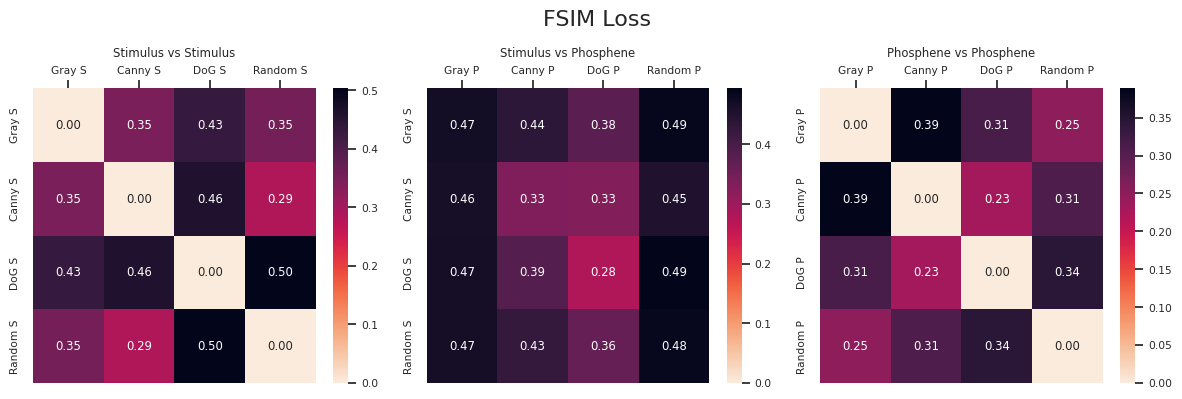

In [123]:
import piq
torch.use_deterministic_algorithms(False)

fsim_loss = piq.FSIMLoss(chromatic=False, min_length=7, scales=4).cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, fsim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='FSIM Loss')

### Learned Perceptual Image Patch Similarity (LPIPS)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


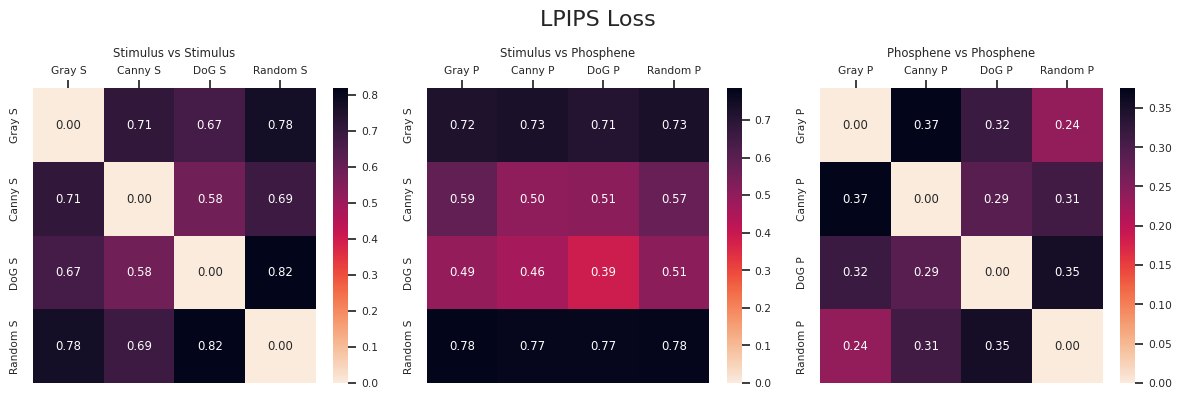

In [124]:
LPIPS_loss = piq.LPIPS()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, LPIPS_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='LPIPS Loss')

### Perceptual Image-Error Assessment through Pairwise Preference (PieAPP)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/pieapp.py:171: UserWarning: The original PieAPP supports only RGB images.The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original PieAPP supports only RGB images.'


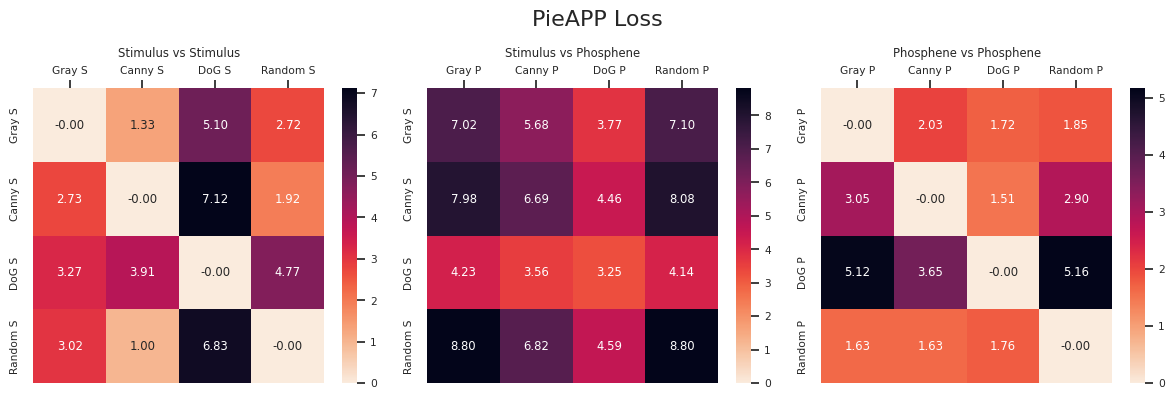

In [125]:
pieapp_loss = piq.PieAPP()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, pieapp_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='PieAPP Loss')

### Deep Image Structure and Texture Similarity (DISTS)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


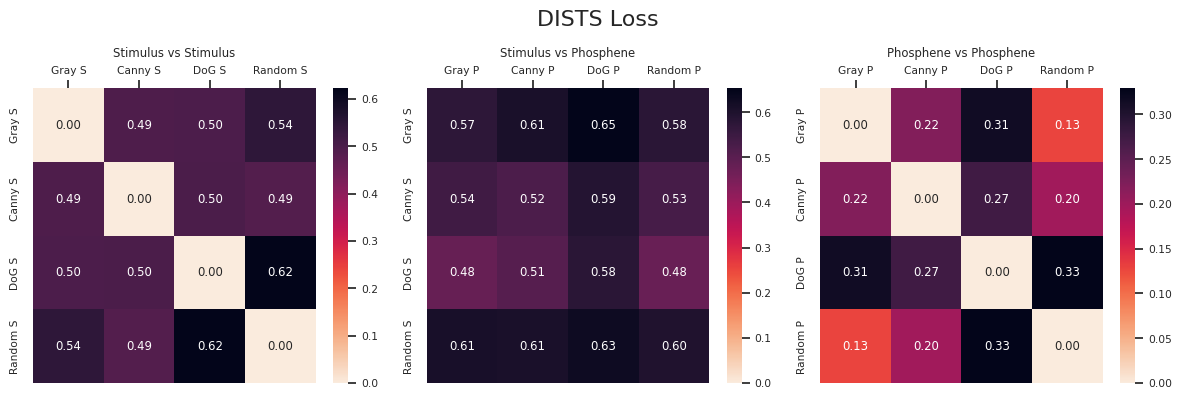

In [126]:
dists_loss = piq.DISTS()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, dists_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='DISTS Loss')

### Content Loss

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


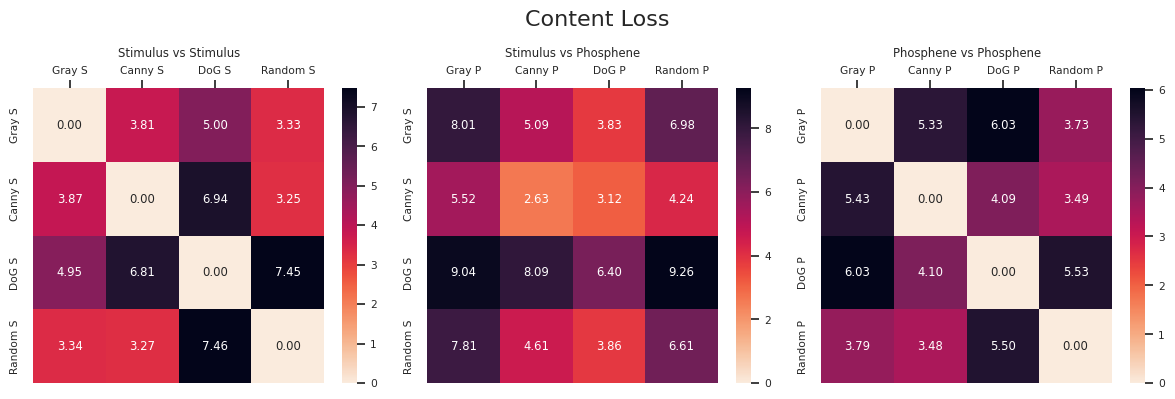

In [127]:
contentloss = piq.ContentLoss(feature_extractor='vgg19', normalize_features=False, layers = ['relu2_2'], distance="swd")

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, contentloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Content Loss')

### Strucural Similarity (SSIM)

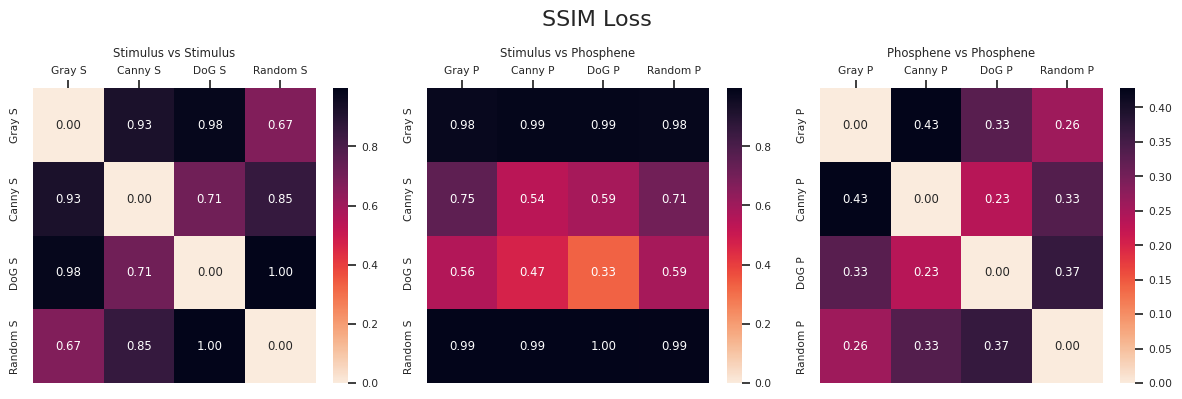

In [128]:
ssim_loss = piq.SSIMLoss()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, ssim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='SSIM Loss')

### Multi-Scale Structural Similarity (MS-SSIM)

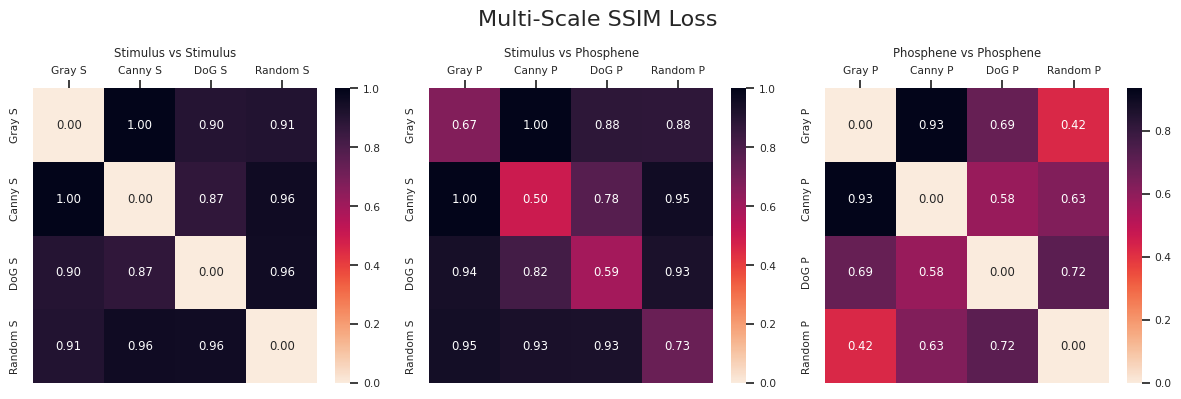

In [129]:
msssim_loss = piq.MultiScaleSSIMLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, msssim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Multi-Scale SSIM Loss')

### Information Content Weighted Structural Similarity (IW-SSIM)

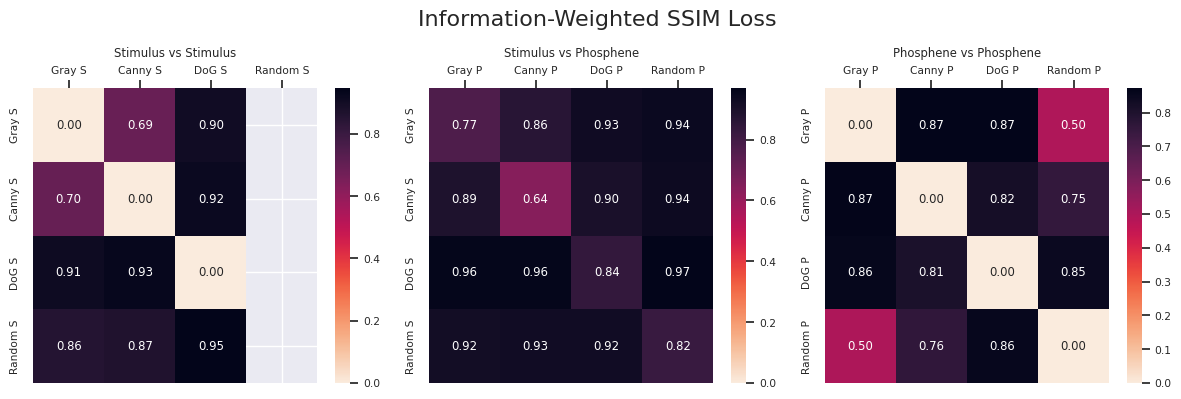

In [130]:
iwssim_loss = piq.InformationWeightedSSIMLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, iwssim_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Information-Weighted SSIM Loss')

### Visual Information Fidelity (VIFp)

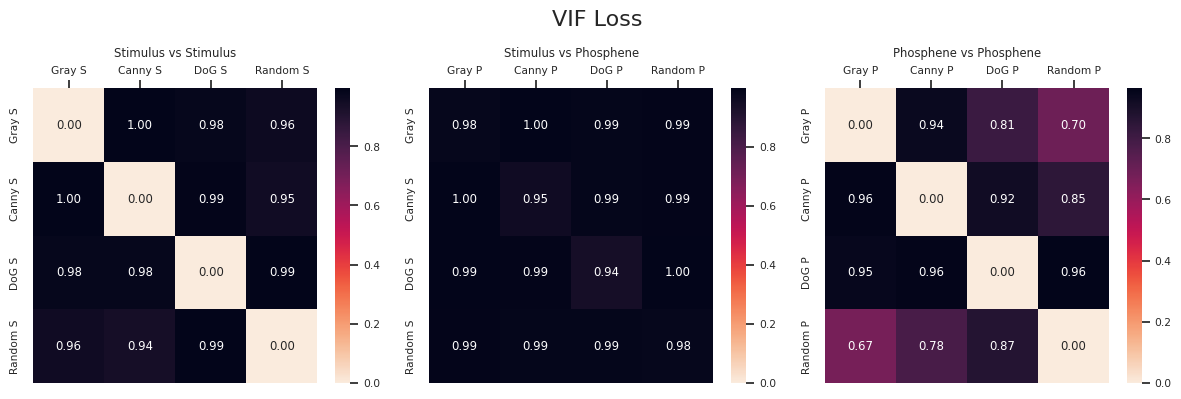

In [131]:
vifloss = piq.VIFLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, vifloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='VIF Loss')

### Spectral Residual based Similarity Measure (SR-SIM)

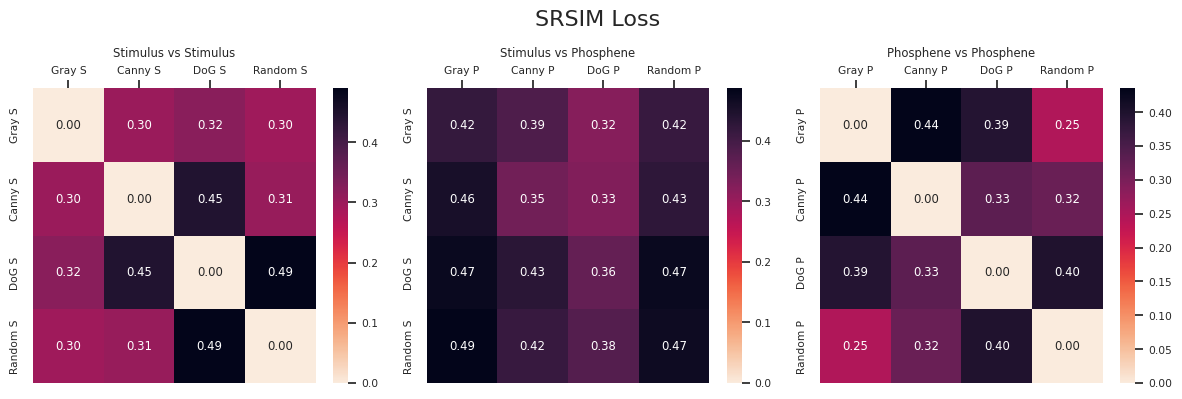

In [132]:
srsimloss = piq.SRSIMLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, srsimloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='SRSIM Loss')

### Gradient Magnitude Similarity Deviation (GMSD)

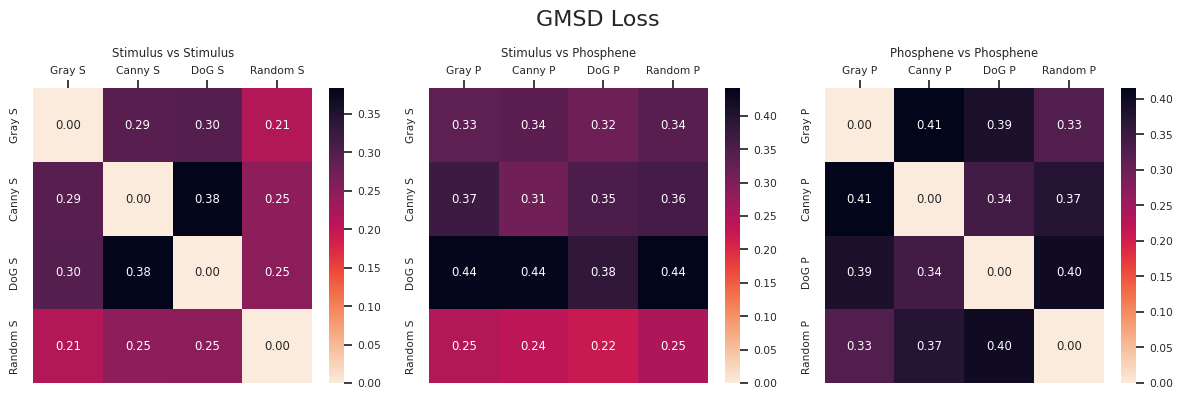

In [133]:
loss = piq.GMSDLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='GMSD Loss')

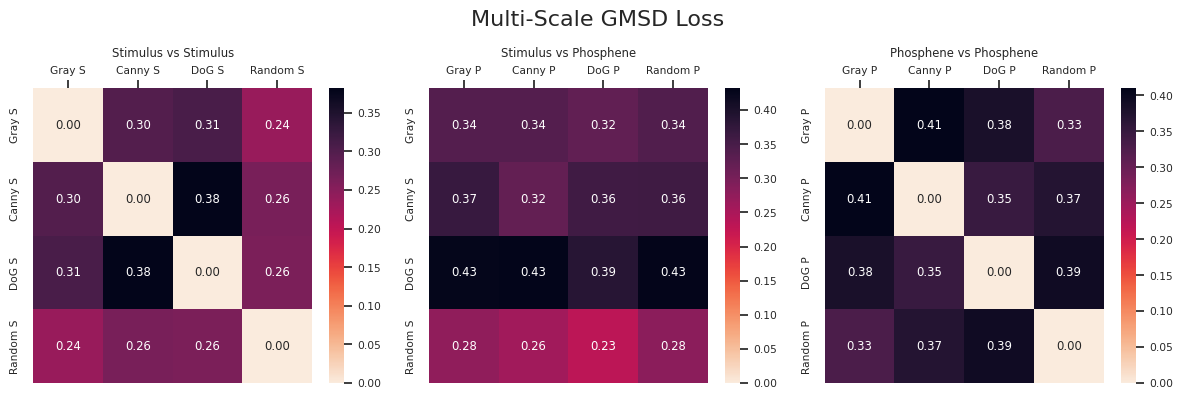

In [134]:
loss = piq.MultiScaleGMSDLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Multi-Scale GMSD Loss')

### Visual Saliency-induced Index (VSI)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/vsi.py:63: UserWarning: The original VSI supports only RGB images. The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original VSI supports only RGB images. The input images were converted to RGB by copying '


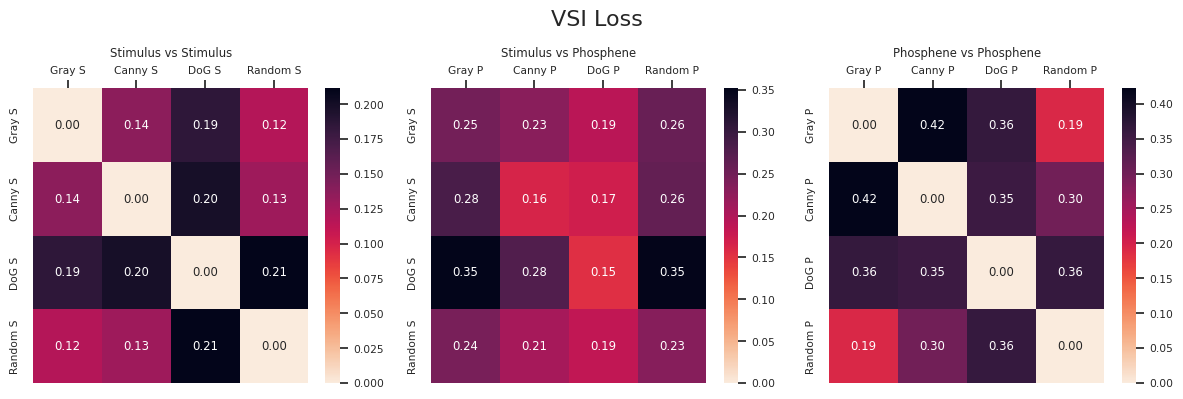

In [135]:
vsiloss = piq.VSILoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, vsiloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='VSI Loss')

### DCT Subband Similarity Index (DSS)

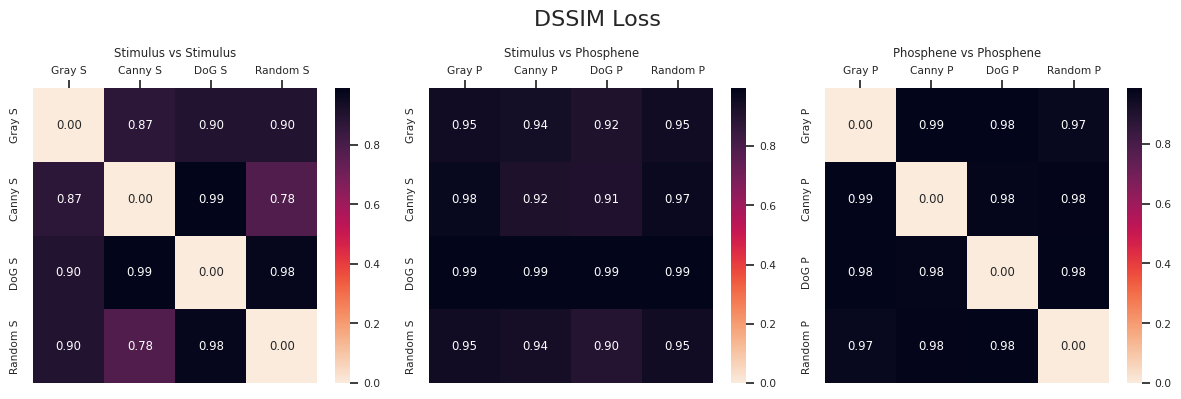

In [136]:
dssloss = piq.DSSLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, dssloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='DSSIM Loss')

### Haar Perceptual Similarity Index (HaarPSI)

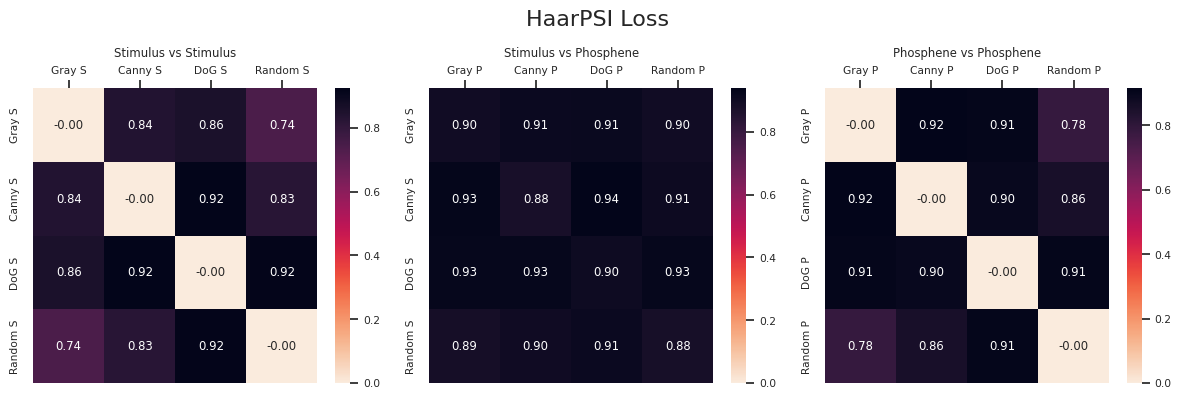

In [137]:
haarloss = piq.HaarPSILoss(scales=3).cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, haarloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='HaarPSI Loss')

### Mean Deviation Similarity Index (MDSI)

/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/mdsi.py:66: UserWarning: The original MDSI supports only RGB images. The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original MDSI supports only RGB images. The input images were converted to RGB by copying '


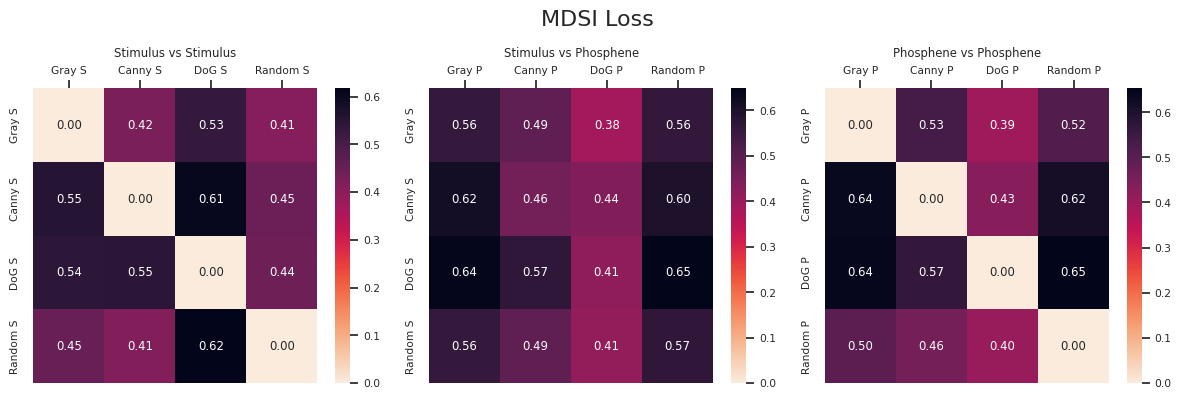

In [138]:
mdsiloss = piq.MDSILoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, mdsiloss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='MDSI Loss')

# MTF

In [158]:
import torch
import torch.nn as nn

class FastMTFLoss(nn.Module):
    def __init__(self, H: int, W: int, eps: float = 1e-8, freq_thresh: float = 0.0):
        """
        Fast, GPU‐vectorized MTF loss with DC normalization and power weighting.

        Args:
          H, W: spatial size of input images
          eps: small constant to avoid divide‐by‐zero
          freq_thresh: minimum normalized stimulus power to include in loss (0=include all)
        """
        super().__init__()
        self.eps = eps
        self.freq_thresh = freq_thresh

        # Precompute integer radius map [H, W]
        ys = torch.arange(H, dtype=torch.float32)
        xs = torch.arange(W, dtype=torch.float32)
        y, x = torch.meshgrid(ys, xs, indexing='ij')
        cy, cx = H//2, W//2
        r = torch.sqrt((y - cy)**2 + (x - cx)**2).round().long()
        r_flat = r.flatten()

        # Count of pixels at each radius
        count = torch.bincount(r_flat)

        self.register_buffer('r_flat', r_flat)
        self.register_buffer('count', count)

    def forward(self, stim: torch.Tensor, phos: torch.Tensor) -> torch.Tensor:
        """
        stim, phos: [B, 1, H, W]
        returns: scalar loss
        """
        B, C, H, W = stim.shape
        assert C == 1, "Input must be single‐channel"

        def radial_profile_batch(x: torch.Tensor):
            # x: [B, H, W]
            F = torch.fft.fft2(x)
            F = torch.fft.fftshift(F, dim=(1,2))
            mag = F.abs().flatten(1)  # [B, H*W]
            # radial sums via bincount per batch
            radial_sum = torch.stack([
                torch.bincount(self.r_flat,
                               weights=mag[b],
                               minlength=self.count.numel())
                for b in range(B)
            ], dim=0).float()  # [B, R]
            return radial_sum / (self.count.unsqueeze(0).float() + self.eps)

        # compute radial profiles
        rp_st = radial_profile_batch(stim[:,0])
        rp_ph = radial_profile_batch(phos[:,0])

        # DC normalization
        dc_st = rp_st[:, :1]  # [B,1]
        dc_ph = rp_ph[:, :1]
        rst_norm = rp_st / (dc_st + self.eps)  # [B, R]
        rph_norm = rp_ph / (dc_ph + self.eps)

        # compute MTF
        mtf = rph_norm / (rst_norm + self.eps)  # [B, R]

        # build power‐based weights
        w = rst_norm / (rst_norm.sum(dim=1, keepdim=True) + self.eps)  # [B, R]

        # optional frequency threshold mask
        if self.freq_thresh > 0:
            mask = (rst_norm >= self.freq_thresh).float()
            w = w * mask
            # renormalize weights after masking
            w = w / (w.sum(dim=1, keepdim=True) + self.eps)

        # weighted MSE to ideal (1.0)
        loss = (w * (mtf - 1.0).pow(2)).sum(dim=1).mean()
        return loss

# Example instantiation:
# mtf_loss = FastMTFLoss(256, 256, eps=1e-8, freq_thresh=0.01).cuda()

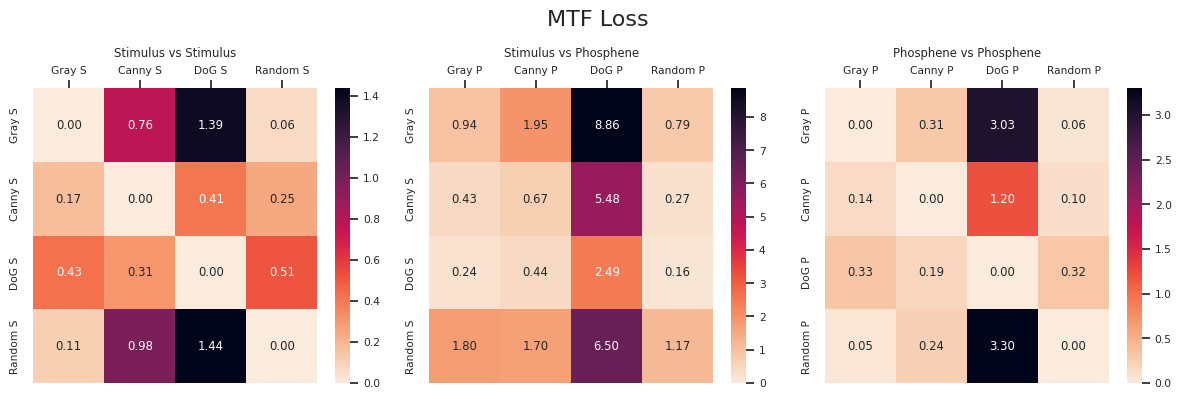

In [166]:
mtf_loss = FastMTFLoss(256, 256, freq_thresh=0.01).cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, mtf_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='MTF Loss')

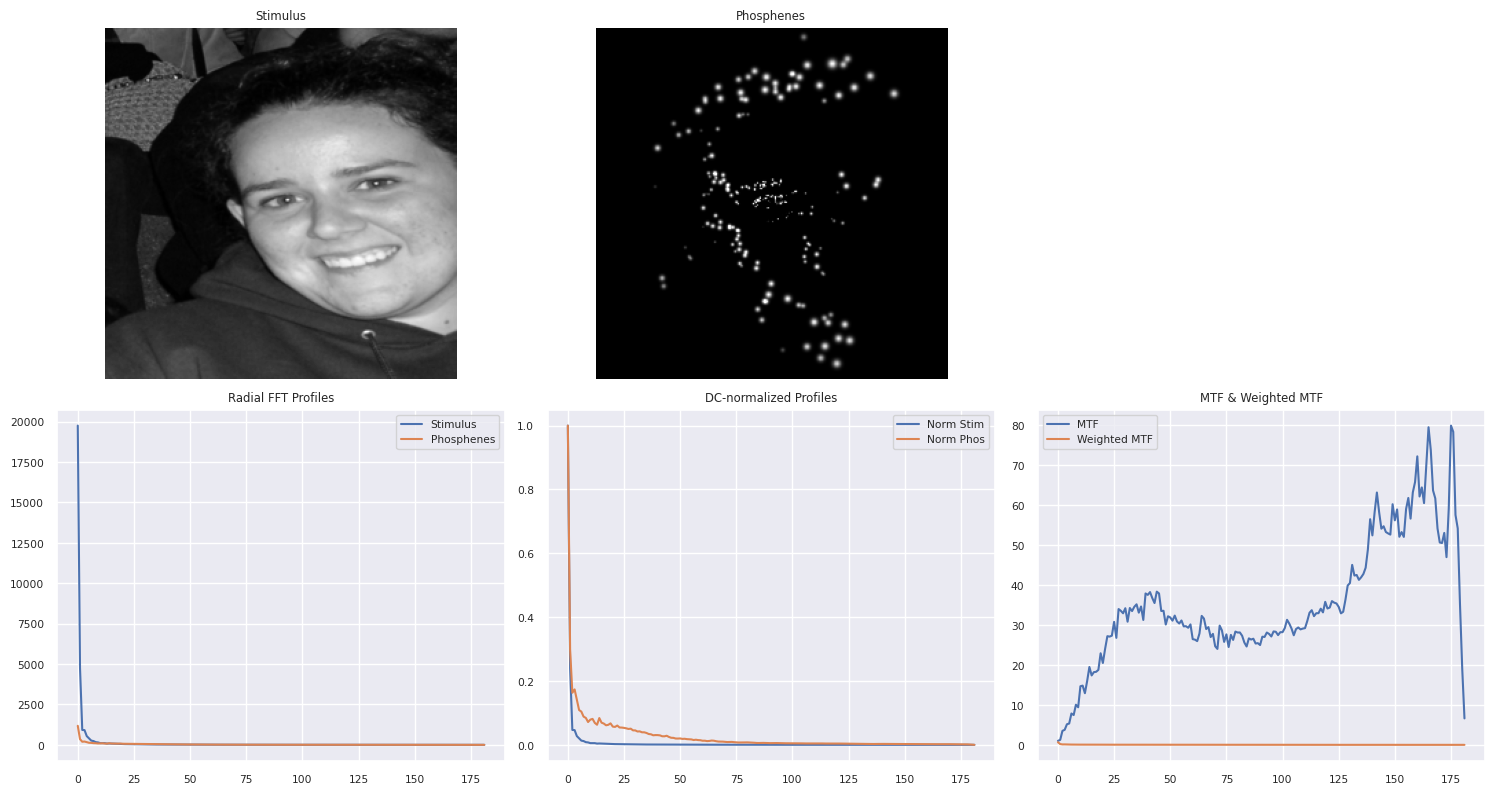

In [167]:
# --- Visualization of MTF components for one example ---

import numpy as np
import matplotlib.pyplot as plt

# Pick your example index:
idx = 0
stim = image_processing_dict[idx]['grayscale']['stim'][0,0].cpu().numpy()
phos = image_processing_dict[idx]['DoG_response']['phosphenes'][0,0].cpu().numpy()

eps = 1e-8

def radial_profile(img):
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    H, W = mag.shape
    y, x = np.indices((H,W))
    cx, cy = W//2, H//2
    r = np.sqrt((x-cx)**2 + (y-cy)**2).astype(int).flatten()
    m = mag.flatten()
    max_r = r.max()
    sum_r = np.bincount(r, weights=m, minlength=max_r+1)
    count = np.bincount(r, minlength=max_r+1)
    return sum_r / (count + eps)

# Compute radial profiles
rp_st = radial_profile(stim)
rp_ph = radial_profile(phos)
L = min(len(rp_st), len(rp_ph))
freqs = np.arange(L)

# DC normalization
rp_st_n = rp_st[:L] / (rp_st[0] + eps)
rp_ph_n = rp_ph[:L] / (rp_ph[0] + eps)

# Weighting
w = rp_st_n / (rp_st_n.sum() + eps)

# MTF
mtf = rp_ph_n / (rp_st_n + eps)

# Plot
fig, axes = plt.subplots(2, 3, figsize=(15,8))

axes[0,0].imshow(stim, cmap='gray')
axes[0,0].set_title('Stimulus')
axes[0,0].axis('off')

axes[0,1].imshow(phos, cmap='gray')
axes[0,1].set_title('Phosphenes')
axes[0,1].axis('off')

axes[0,2].axis('off')

axes[1,0].plot(freqs, rp_st[:L], label='Stimulus')
axes[1,0].plot(freqs, rp_ph[:L], label='Phosphenes')
axes[1,0].set_title('Radial FFT Profiles')
axes[1,0].legend()

axes[1,1].plot(freqs, rp_st_n, label='Norm Stim')
axes[1,1].plot(freqs, rp_ph_n, label='Norm Phos')
axes[1,1].set_title('DC-normalized Profiles')
axes[1,1].legend()

axes[1,2].plot(freqs, mtf, label='MTF')
axes[1,2].plot(freqs, w * mtf, label='Weighted MTF')
axes[1,2].set_title('MTF & Weighted MTF')
axes[1,2].legend()

plt.tight_layout()
plt.show()


# FSD

Weighted FSD loss: 6.4966


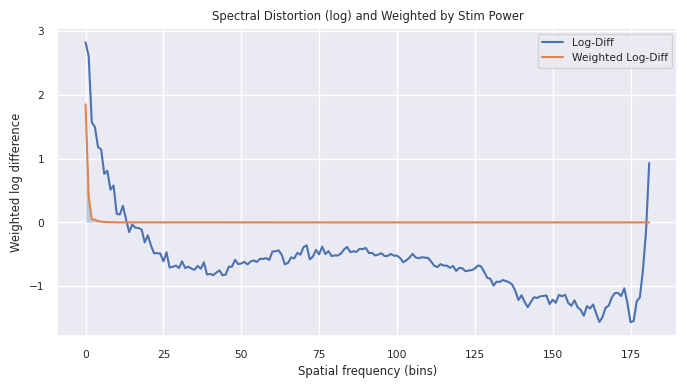

In [175]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Reuse numpy radial_profile defined earlier
def radial_profile(img: np.ndarray, eps: float = 1e-8) -> np.ndarray:
    f = np.fft.fftshift(np.fft.fft2(img))
    mag = np.abs(f)
    H, W = mag.shape
    y, x = np.indices((H, W))
    cx, cy = W//2, H//2
    r = np.sqrt((x - cx)**2 + (y - cy)**2).astype(int).flatten()
    m = mag.flatten()
    max_r = r.max()
    sum_r = np.bincount(r, weights=m, minlength=max_r+1)
    count = np.bincount(r, minlength=max_r+1)
    return sum_r / (count + eps)

class FSDLoss(nn.Module):
    """
    Fourier Spectral Distortion with spectral weighting by stimulus power.
    """
    def __init__(self, eps: float = 1e-8):
        super().__init__()
        self.eps = eps

    def forward(self, stim: torch.Tensor, phos: torch.Tensor) -> torch.Tensor:
        """
        stim, phos: [B,1,H,W]
        returns: scalar loss
        """
        # Only batch size 1 for simplicity, extendable to B>1
        st = stim.detach().cpu().numpy()[0,0]
        ph = phos.detach().cpu().numpy()[0,0]

        # radial profiles
        rp_st = radial_profile(st, eps=self.eps)
        rp_ph = radial_profile(ph, eps=self.eps)
        L = min(rp_st.size, rp_ph.size)
        rp_st, rp_ph = rp_st[:L], rp_ph[:L]

        # weight by stimulus power (normalized)
        w = rp_st / (rp_st.sum() + self.eps)  # [L]

        # spectral distortion: squared log difference
        diff = np.log(rp_st + self.eps) - np.log(rp_ph + self.eps)
        weighted_sq = w * (diff ** 2)

        loss = float(weighted_sq.sum())
        return torch.tensor(loss, device=stim.device, dtype=torch.float32)

# Example visualization for a single image
idx = 0
stim = image_processing_dict[idx]['grayscale']['stim'][0,0].cpu().numpy()
phos = image_processing_dict[idx]['DoG_response']['phosphenes'][0,0].cpu().numpy()

# Compute profiles and weighted log-difference
rp_st = radial_profile(stim)
rp_ph = radial_profile(phos)
L = min(rp_st.size, rp_ph.size)
freqs = np.arange(L)

rp_st, rp_ph = rp_st[:L], rp_ph[:L]
w = rp_st / (rp_st.sum() + 1e-8)
log_diff = np.log(rp_st + 1e-8) - np.log(rp_ph + 1e-8)
weighted_diff = w * log_diff

# Compute and print loss
wsd_loss = FSDLoss()(torch.from_numpy(stim[None,None]).cuda(), 
                              torch.from_numpy(phos[None,None]).cuda())
print(f"Weighted FSD loss: {wsd_loss.item():.4f}")

# Plot weighted spectral distortion
plt.figure(figsize=(8,4))
plt.plot(freqs, log_diff, label='Log-Diff')
plt.plot(freqs, weighted_diff, label='Weighted Log-Diff')
plt.fill_between(freqs, 0, weighted_diff, alpha=0.3)
plt.title('Spectral Distortion (log) and Weighted by Stim Power')
plt.xlabel('Spatial frequency (bins)')
plt.ylabel('Weighted log difference')
plt.legend()
plt.show()


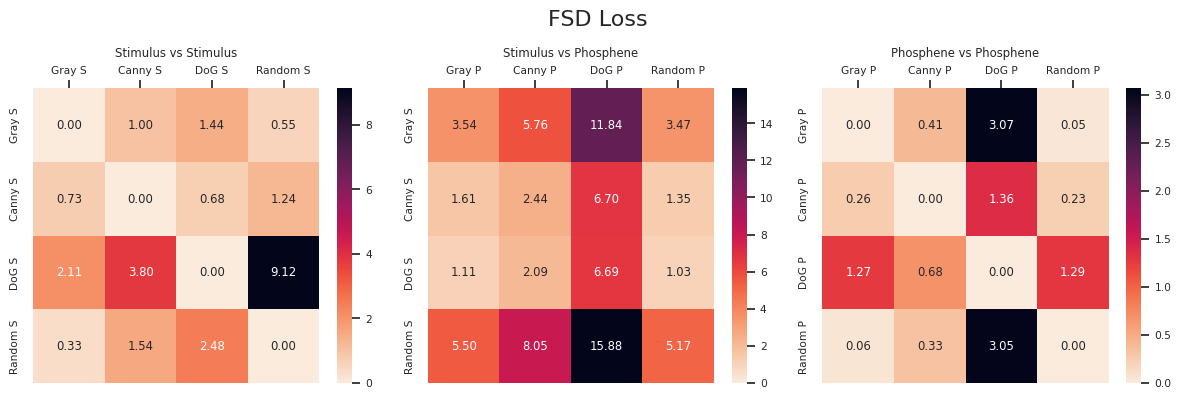

In [176]:
fsd_loss = FSDLoss().cuda()

stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, fsd_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='FSD Loss')

# Point measures

In [183]:
# In your codebase (e.g. spatial_frequency/losses.py), add:

import numpy as np
import torch
import torch.nn as nn
from scipy.ndimage import label, center_of_mass
from scipy.spatial import cKDTree

def extract_point_set(binary_img: np.ndarray) -> np.ndarray:
    """
    From a 2D binary image, label connected components and return
    the centroids as an (N,2) array of (y,x) floats.
    """
    labeled, n = label(binary_img)
    if n == 0:
        return np.empty((0,2), dtype=np.float32)
    centroids = center_of_mass(binary_img, labeled, range(1, n+1))
    return np.array(centroids, dtype=np.float32)

def chamfer_distance_np(ptsA: np.ndarray, ptsB: np.ndarray) -> float:
    if ptsA.shape[0] == 0 or ptsB.shape[0] == 0:
        return np.inf
    treeA = cKDTree(ptsA)
    treeB = cKDTree(ptsB)
    dA, _ = treeB.query(ptsA, k=1)
    dB, _ = treeA.query(ptsB, k=1)
    return 0.5 * (dA.mean() + dB.mean())

def hausdorff_distance_np(ptsA: np.ndarray, ptsB: np.ndarray) -> float:
    if ptsA.shape[0] == 0 or ptsB.shape[0] == 0:
        return np.inf
    treeA = cKDTree(ptsA)
    treeB = cKDTree(ptsB)
    dA, _ = treeB.query(ptsA, k=1)
    dB, _ = treeA.query(ptsB, k=1)
    return float(max(dA.max(), dB.max()))

class ChamferDistanceLoss(nn.Module):
    """
    Torch loss wrapper for Chamfer distance between a DoG‐contour map
    and a phosphene point‐pattern.
    """
    def __init__(self, stim_thresh: float = None, phos_thresh: float = 0.5):
        """
        Args:
          stim_thresh: if None, use mean of DoG stimulus to binarize
          phos_thresh: fraction of max(phos) to threshold phosphene map
        """
        super().__init__()
        self.stim_thresh = stim_thresh
        self.phos_thresh = phos_thresh

    def forward(self, stim: torch.Tensor, phos: torch.Tensor) -> torch.Tensor:
        # stim, phos: [B,1,H,W]  (we assume B=1 here)
        st_np = stim.detach().cpu().numpy()[0,0]
        ph_np = phos.detach().cpu().numpy()[0,0]

        # Binarize stimulus contour by threshold
        thr = self.stim_thresh if self.stim_thresh is not None else st_np.mean()
        stim_bin = (st_np > thr)

        # Binarize phosphene map
        ph_bin = (ph_np > self.phos_thresh * ph_np.max())

        # Extract centroids
        pts_stim = extract_point_set(stim_bin)
        pts_phos = extract_point_set(ph_bin)

        # Compute Chamfer
        d = chamfer_distance_np(pts_stim, pts_phos)
        return torch.tensor(d, device=stim.device, dtype=torch.float32)

class HausdorffDistanceLoss(nn.Module):
    """
    Torch loss wrapper for Hausdorff distance between contour and phosphenes.
    """
    def __init__(self, stim_thresh: float = None, phos_thresh: float = 0.5):
        super().__init__()
        self.stim_thresh = stim_thresh
        self.phos_thresh = phos_thresh

    def forward(self, stim: torch.Tensor, phos: torch.Tensor) -> torch.Tensor:
        st_np = stim.detach().cpu().numpy()[0,0]
        ph_np = phos.detach().cpu().numpy()[0,0]

        thr = self.stim_thresh if self.stim_thresh is not None else st_np.mean()
        stim_bin = (st_np > thr)
        ph_bin   = (ph_np > self.phos_thresh * ph_np.max())

        pts_stim = extract_point_set(stim_bin)
        pts_phos = extract_point_set(ph_bin)

        d = hausdorff_distance_np(pts_stim, pts_phos)
        return torch.tensor(d, device=stim.device, dtype=torch.float32)

# Example of how to evaluate across your matrix:
# from spatial_frequency.losses import ChamferDistanceLoss, HausdorffDistanceLoss
# cd_loss = ChamferDistanceLoss().cuda()
# hd_loss = HausdorffDistanceLoss().cuda()
# stim_stim, stim_phos, phos_phos = evaluate_loss_matrices(image_processing_dict, cd_loss)
# plot_loss_matrices(..., title='Chamfer Distance')


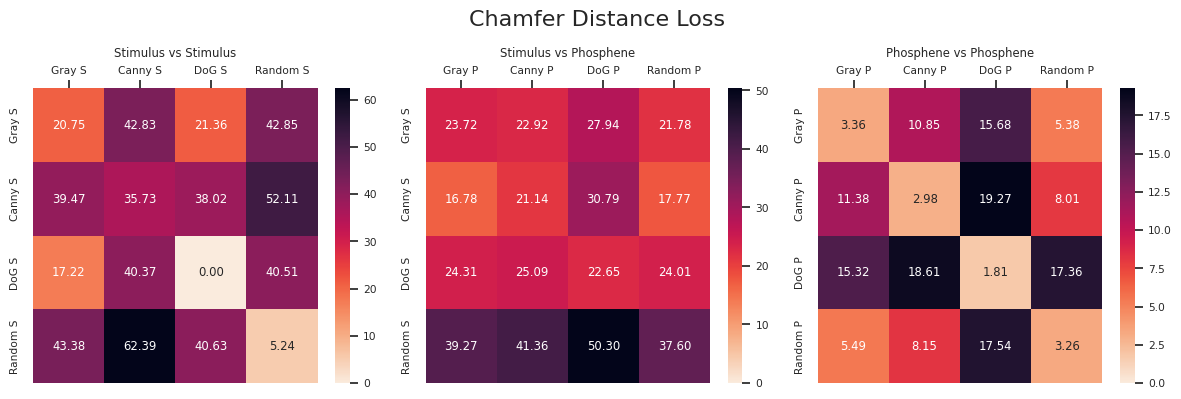

In [179]:
chamfer_distance_loss = ChamferDistanceLoss().cuda()
stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, chamfer_distance_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Chamfer Distance Loss')

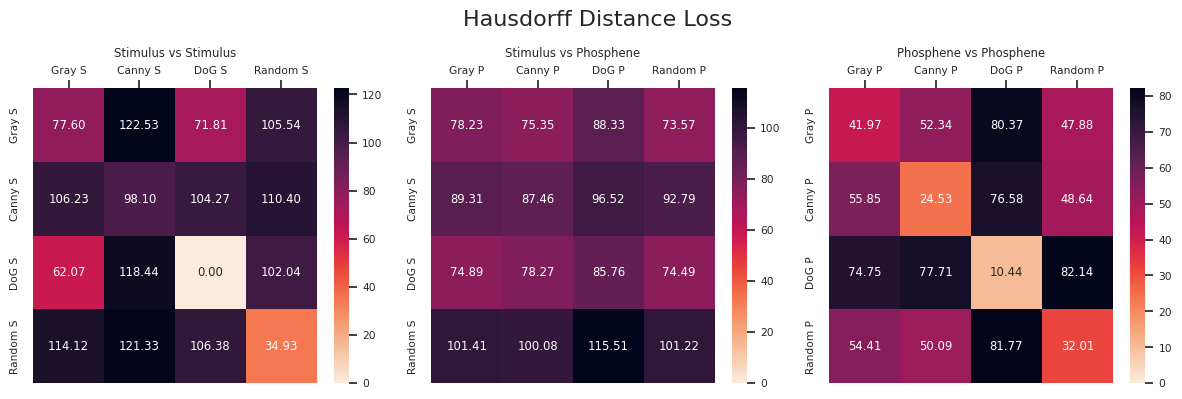

In [180]:
hausdorff_distance_loss = HausdorffDistanceLoss().cuda()
stim_stim_matrix, stim_phos_matrix, phos_phos_matrix = evaluate_loss_matrices(image_processing_dict, hausdorff_distance_loss)
plot_loss_matrices(stim_stim_matrix, stim_phos_matrix, phos_phos_matrix, labels_stim, labels_phos, title='Hausdorff Distance Loss')